## Data Preprocessing Pipeline

### Name: Shane Bowen

## Import Libraries and Load Dataset

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import seaborn as sns
import operator
from scipy import stats
from sklearn.model_selection import learning_curve, ShuffleSplit, KFold
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler,OneHotEncoder,MinMaxScaler,FunctionTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer 
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, LogisticRegression, LassoCV
from matplotlib import pyplot
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

#df = pd.read_csv('../reports/company_report_sorted.csv', header=0, index_col=["company_id", "time"])
df = pd.read_csv('../reports/company_report_sorted.csv', header=0)

In [2]:
# Remove any duplicated records from data
df = df.drop_duplicates(keep=False)

In [3]:
df.describe()

,company_id,date,month,year,is_weekend,avg_pesq_score,quality_too_poor,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests
count,80172.000000,80172.00000,80172.000000,80172.000000,80172.000000,80172.000000,80172.000000,80172.000000,80172.000000,80172.000000,80172.000000,80172.000000,80172.000000,38278.000000,80172.00000,80172.000000
mean,115.270843,15.64283,5.961308,2019.007634,0.285948,1.561956,1.010739,12.334431,1.193023,631.839060,0.829354,62.318889,2.691675,17201.604185,0.47670,688.438233
std,79.333169,8.78044,3.415485,0.750907,0.451867,1.886573,8.951419,67.955426,17.460154,1902.007178,1.035513,308.479887,26.638311,61817.727161,0.49946,4168.578479
min,1.000000,1.00000,1.000000,2018.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,53.000000,8.00000,3.000000,2018.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,583.000000,0.00000,0.000000
50%,103.000000,16.00000,5.000000,2019.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,1.000000,1.000000,0.000000,2000.000000,0.00000,12.000000
75%,173.000000,23.00000,9.000000,2020.000000,1.000000,3.791667,0.000000,2.000000,0.000000,216.000000,1.000000,26.000000,0.000000,7200.000000,1.00000,159.000000
max,364.000000,31.00000,12.000000,2020.000000,1.000000,4.500000,627.000000,4492.000000,1258.000000,13277.440000,6.000000,4267.000000,2337.000000,400000.000000,1.00000,57105.000000


## Data Visualization

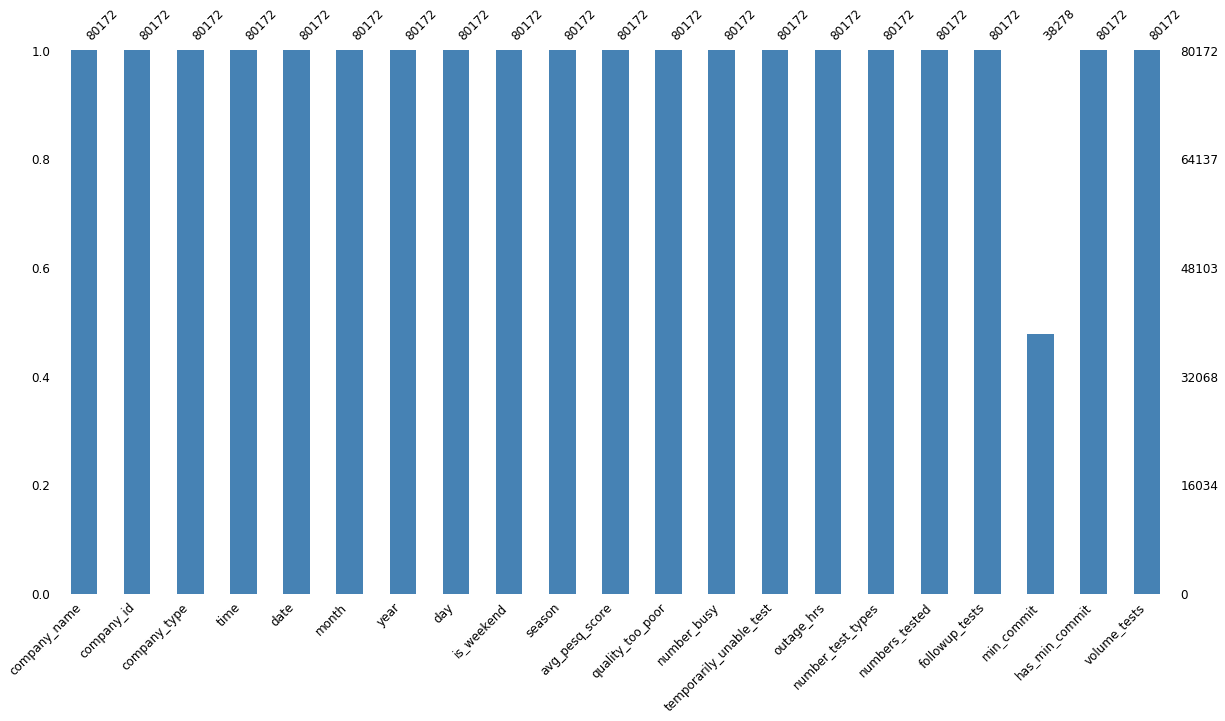

In [4]:
msno.bar(df, figsize=(20, 10), fontsize=12, color='steelblue')

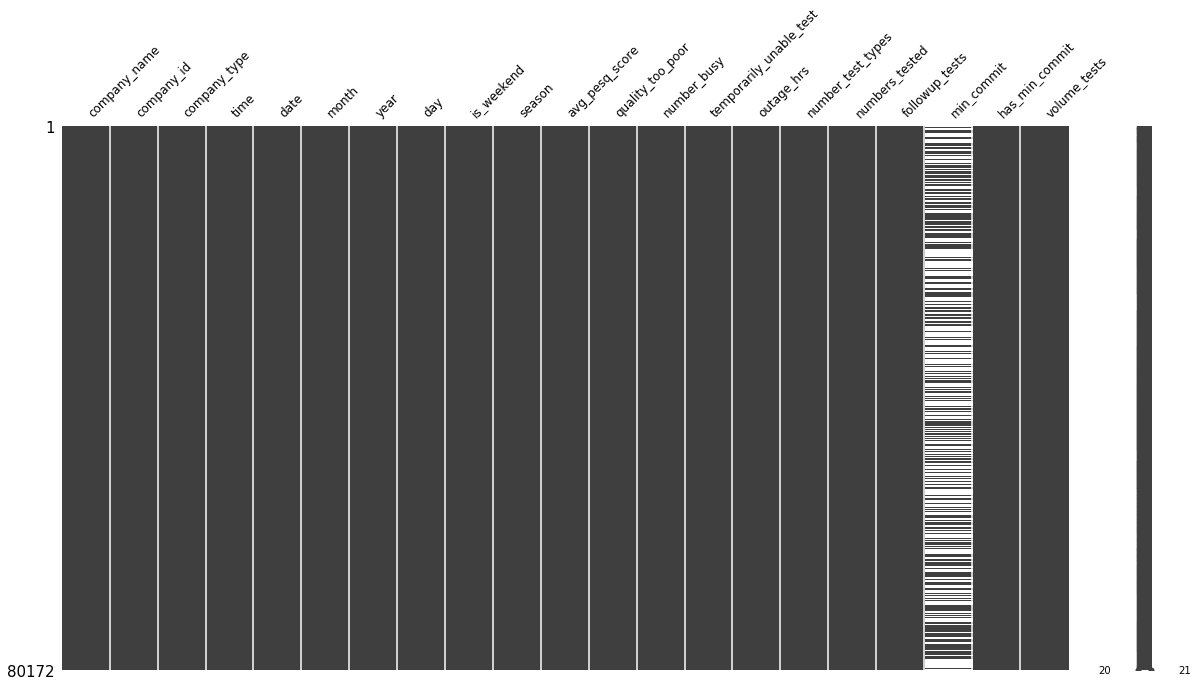

In [5]:
msno.matrix(df, figsize=(20, 10), fontsize=12)

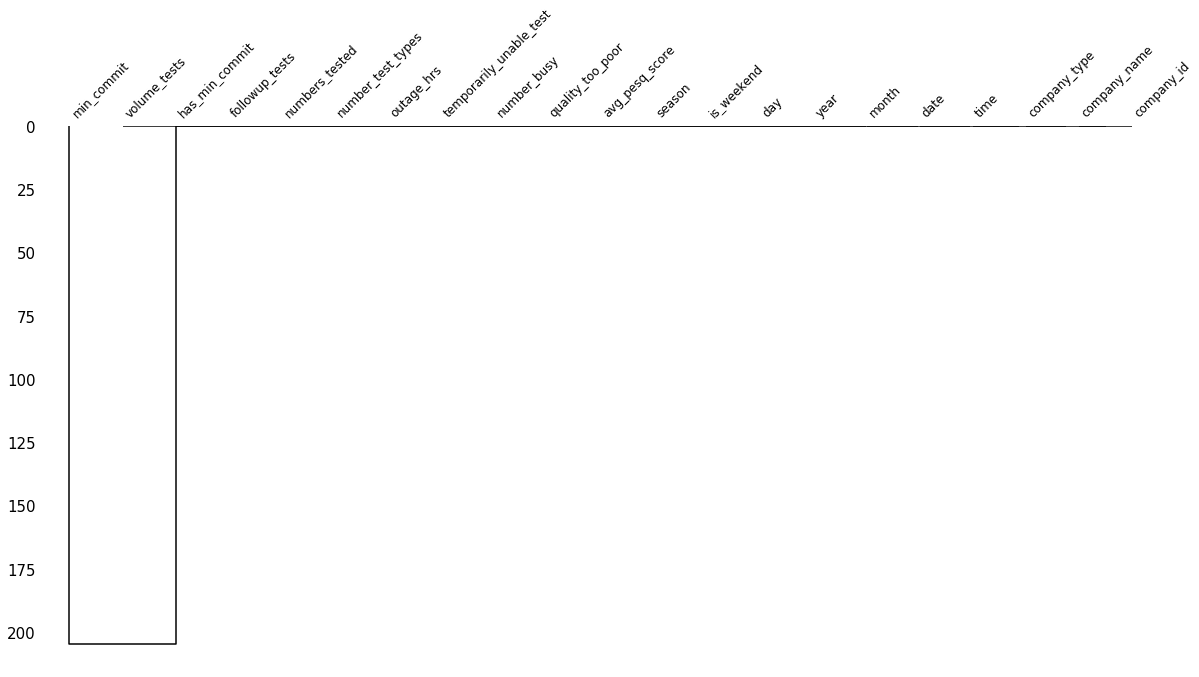

In [6]:
msno.dendrogram(df, figsize=(20, 10), fontsize=12)

## Data Cleaning

In [7]:
# Find the number of missing data in the dataset
df.apply(lambda x: sum(x.isnull()), axis=0)

company_name                   0
company_id                     0
company_type                   0
time                           0
date                           0
month                          0
year                           0
day                            0
is_weekend                     0
season                         0
avg_pesq_score                 0
quality_too_poor               0
number_busy                    0
temporarily_unable_test        0
outage_hrs                     0
number_test_types              0
numbers_tested                 0
followup_tests                 0
min_commit                 41894
has_min_commit                 0
volume_tests                   0
dtype: int64

In [8]:
empty_min_commit = df[df['min_commit'].isnull() ]
empty_min_commit

,company_name,company_id,company_type,time,date,month,year,day,is_weekend,season,...,quality_too_poor,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests
4,Marchex,10,Enterprise,2018-01-01,1,1,2018,Mon,0,Winter,...,0,0,0,0.0,1,13,0,NaN,0,672
6,Airbnb,17,Enterprise,2018-01-01,1,1,2018,Mon,0,Winter,...,3,0,0,0.0,1,37,0,NaN,0,1792
12,Mastercard,49,Enterprise,2018-01-01,1,1,2018,Mon,0,Winter,...,0,0,0,24.0,1,10,0,NaN,0,82
18,Tata Communications,75,Enterprise,2018-01-01,1,1,2018,Mon,0,Winter,...,0,0,0,0.0,0,0,0,NaN,0,15
21,Amazon Chime,100,Enterprise,2018-01-01,1,1,2018,Mon,0,Winter,...,2,5,0,24.0,1,68,0,NaN,0,340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80159,NiceInContact,215,Enterprise,2020-06-20,20,6,2020,Sat,1,Summer,...,0,0,0,24.0,0,0,0,NaN,0,8
80164,Johnson & Johnson,245,Enterprise,2020-06-20,20,6,2020,Sat,1,Summer,...,0,0,1,0.0,1,72,0,NaN,0,143
80167,Cisco,255,Enterprise,2020-06-20,20,6,2020,Sat,1,Summer,...,0,2,0,168.0,2,40,3,NaN,0,265
80170,Sykes,285,Enterprise,2020-06-20,20,6,2020,Sat,1,Summer,...,0,0,0,0.0,0,0,0,NaN,0,0


In [9]:
df['min_commit'] = df['min_commit'].fillna(0)

In [10]:
df['min_commit'].count()

80172

## Distribution Analysis

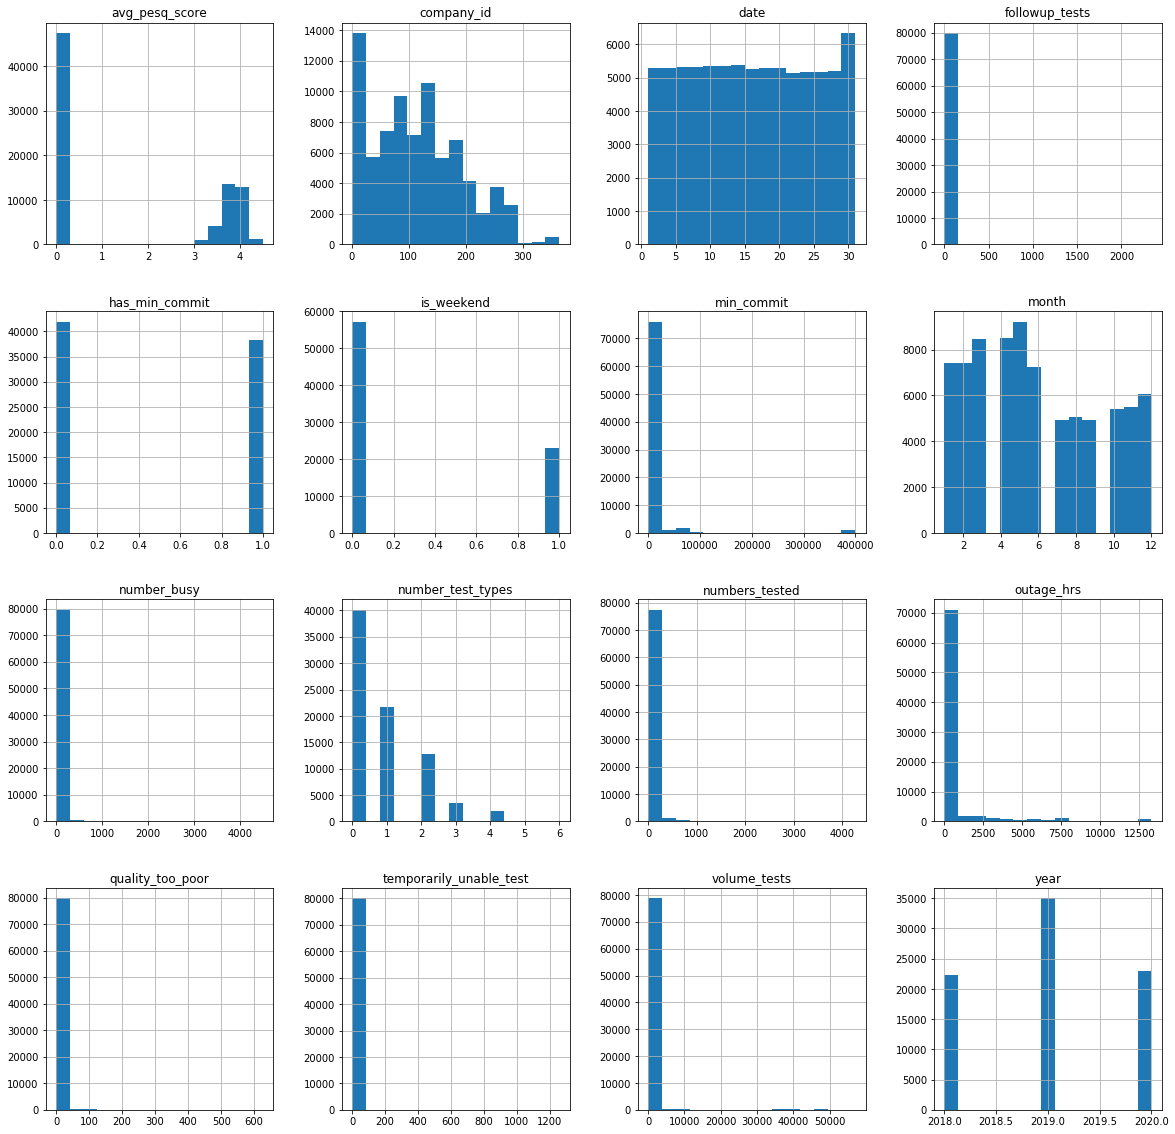

In [11]:
df.hist(bins=15, figsize=(20, 20));

## Handling Outliers

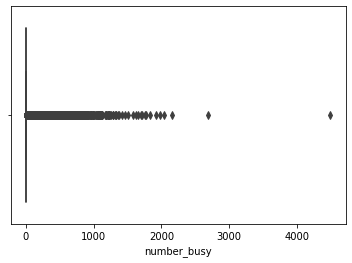

In [12]:
# plot number_busy outliers
sns.boxplot(x=df["number_busy"])

In [13]:
# count number of outliers
print((df[['number_busy']] > 2600).sum())
df[df['number_busy'] > 2600]

number_busy    2
dtype: int64


,company_name,company_id,company_type,time,date,month,year,day,is_weekend,season,...,quality_too_poor,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests
27749,Google,2,Enterprise,2019-03-08,8,3,2019,Fri,0,Spring,...,34,4492,0,6478.70,3,3003,2337,400000.0,1,42615
48926,Tata Communications,75,Enterprise,2019-10-19,19,10,2019,Sat,1,Autumn,...,2,2680,0,2159.97,2,110,0,27272.0,1,5164


In [14]:
# remove outliers for number_busy
df = df[df['number_busy'] < 2600]

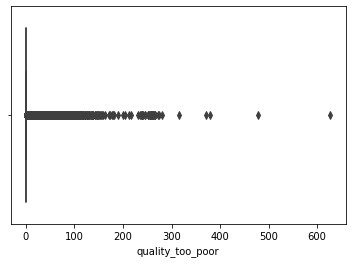

In [15]:
# plot quality_too_poor outliers
sns.boxplot(x=df["quality_too_poor"])

In [16]:
# count number of outliers
print((df[['quality_too_poor']] > 450).sum())
df[df['quality_too_poor'] > 450]

quality_too_poor    2
dtype: int64


,company_name,company_id,company_type,time,date,month,year,day,is_weekend,season,...,quality_too_poor,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests
9282,Google,2,Enterprise,2018-06-27,27,6,2018,Wed,0,Summer,...,627,469,68,4353.67,3,2718,130,400000.0,1,40609
48585,Intrado,9,Conference,2019-10-16,16,10,2019,Wed,0,Autumn,...,479,33,11,2232.03,3,133,24,0.0,0,7907


In [17]:
# remove outliers for quality_too_poor
df = df[df['quality_too_poor'] < 450]

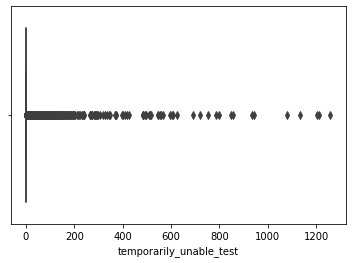

In [18]:
# plot outliers temporarily_unable_test
sns.boxplot(x=df["temporarily_unable_test"])

In [19]:
# count number of outliers
print((df[['temporarily_unable_test']] > 1000).sum())
df[df['temporarily_unable_test'] > 1000]

temporarily_unable_test    5
dtype: int64


,company_name,company_id,company_type,time,date,month,year,day,is_weekend,season,...,quality_too_poor,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests
6430,Google,2,Enterprise,2018-05-11,11,5,2018,Fri,0,Summer,...,7,288,1079,3815.03,3,2457,90,400000.0,1,40026
7138,Google,2,Enterprise,2018-05-23,23,5,2018,Wed,0,Summer,...,17,216,1132,3765.83,3,2541,90,400000.0,1,40182
7870,Google,2,Enterprise,2018-06-04,4,6,2018,Mon,0,Summer,...,6,623,1202,4080.27,3,2500,280,400000.0,1,40047
15839,Google,2,Enterprise,2018-10-05,5,10,2018,Fri,0,Autumn,...,38,519,1258,5141.55,3,2669,350,400000.0,1,44042
25858,Google,2,Enterprise,2019-02-14,14,2,2019,Thurs,0,Spring,...,30,414,1213,5927.93,3,3038,153,400000.0,1,46280


In [20]:
# remove outliers for temporarily_unable_test
df = df[df['temporarily_unable_test'] < 1000]

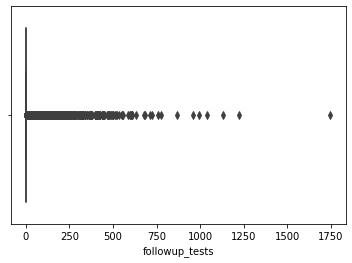

In [21]:
# plot outliers for followup_tests
sns.boxplot(x=df["followup_tests"])

In [22]:
# count number of outliers
print((df[['followup_tests']] > 1200).sum())
df[df['followup_tests'] > 1200]

followup_tests    2
dtype: int64


,company_name,company_id,company_type,time,date,month,year,day,is_weekend,season,...,quality_too_poor,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests
16529,Google,2,Enterprise,2018-10-15,15,10,2018,Mon,0,Autumn,...,2,2155,28,5581.40,3,2862,1747,400000.0,1,45696
23910,Google,2,Enterprise,2019-01-21,21,1,2019,Mon,0,Winter,...,14,1621,0,6110.11,3,3016,1224,400000.0,1,47779


In [23]:
# remove outliers for followup_tests
df = df[df['followup_tests'] < 1200]

## Feature Selection & Preprocessing

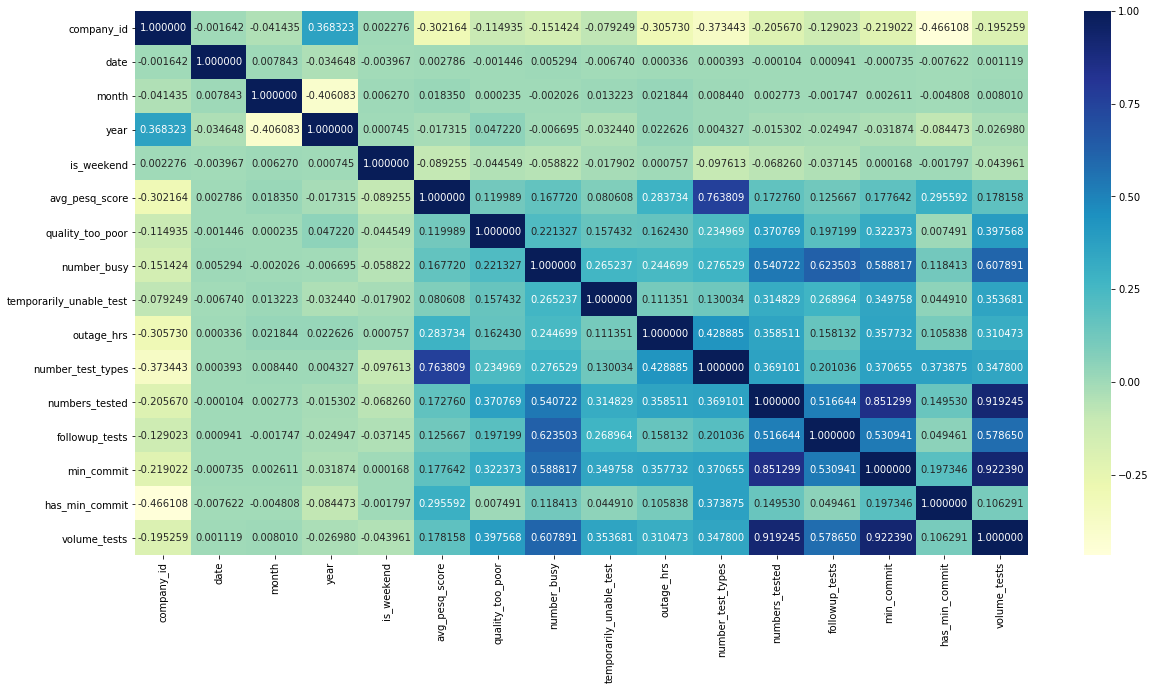

In [24]:
plt.figure(figsize=(20,10))
df_corr= df.corr()
sns.heatmap(df_corr, annot=True, fmt="f", cmap="YlGnBu")

In [25]:
# limit data to first 20 companies (reduce training time)
df = df[(df['company_id'] == 2)]
df

,company_name,company_id,company_type,time,date,month,year,day,is_weekend,season,...,quality_too_poor,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests
1,Google,2,Enterprise,2018-01-01,1,1,2018,Mon,0,Winter,...,4,246,0,2208.22,2,2410,100,400000.0,1,35405
27,Google,2,Enterprise,2018-01-02,2,1,2018,Tues,0,Winter,...,8,952,0,2225.04,2,2444,434,400000.0,1,36978
59,Google,2,Enterprise,2018-01-03,3,1,2018,Wed,0,Winter,...,22,791,0,2230.62,2,2433,370,400000.0,1,36978
91,Google,2,Enterprise,2018-01-04,4,1,2018,Thurs,0,Winter,...,27,824,0,2209.19,2,2441,420,400000.0,1,35899
124,Google,2,Enterprise,2018-01-05,5,1,2018,Fri,0,Winter,...,16,637,0,2232.59,2,2336,420,400000.0,1,34504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79756,Google,2,Enterprise,2020-06-16,16,6,2020,Tues,0,Summer,...,245,166,0,389.12,6,4159,78,400000.0,1,40521
79837,Google,2,Enterprise,2020-06-17,17,6,2020,Wed,0,Summer,...,265,104,0,476.35,6,4157,64,400000.0,1,40658
79921,Google,2,Enterprise,2020-06-18,18,6,2020,Thurs,0,Summer,...,251,250,13,541.85,6,4129,71,400000.0,1,40758
80005,Google,2,Enterprise,2020-06-19,19,6,2020,Fri,0,Summer,...,251,82,16,563.74,6,3332,35,400000.0,1,39230


In [26]:
# split data in train and test sets
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
dftrain, dftest = df[:train_size], df[-test_size:]

In [27]:
# select features columns
df_subset_train = dftrain[['day', 'quality_too_poor', 'number_busy', 'temporarily_unable_test', 'outage_hrs', 'number_test_types', 'numbers_tested', 'followup_tests', 'min_commit', 'has_min_commit', 'volume_tests']].dropna(axis=0)
df_subset_test  = dftest[['day', 'quality_too_poor', 'number_busy', 'temporarily_unable_test', 'outage_hrs', 'number_test_types', 'numbers_tested', 'followup_tests', 'min_commit', 'has_min_commit']]

In [28]:
# also store a list with the names of all predictors
names_all = [c for c in df_subset_train if c not in ['volume_tests']]

# define column groups with same data preparation
cat_columns = ['day']
names_outliers = ['number_busy', 'quality_too_poor', 'temporarily_unable_test', 'followup_tests']
names_no_outliers = list(set(names_all) - set(names_outliers) - set(cat_columns))

In [29]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)
    
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

In [30]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log1p, validate=True)
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            MinMaxScaler()
        )),
        ("cat_columns", make_pipeline(
            ColumnSelector(columns=cat_columns),
            SimpleImputer(strategy='constant', fill_value='missing'),
            OneHotEncoder(handle_unknown='ignore')
        )),
    ])
)

In [31]:
# train set
X = df_subset_train.iloc[:,0:10].values #input columns
y = df_subset_train.iloc[:,10].values   #output column, volume_tests
#test set
Xtest = df_subset_test.iloc[:,0:10].values #input columns

## Train & Test the Model

In [32]:
# store results of algorithms
scores = {}
predictions = {}

### Algorithm 1 - Support Vector Regression
Support Vector Regression(SVR) is a regression algorithm. The SVR uses the same principles as the SVM for classification, with only a few minor differences. Because the output is a real number it becomes very difficult to predict the information at hand, which has infinite possibilities. A margin of tolerance(epsilon) is set in approximation to the SVM. THe main idea is to minimize error, individualizing the hyperplance which maximizes the margin, keeping in ind the part of the error is tolerated. The parameters tuned:

1. *C* - This is the regularization parameter which helps avoid overfitting. Must be a positive value. A large C will give low bias and high variance while a small C will give a higher bias and lower variance.
2. *epsilon* - This defines a margin of tolerance where no penalty is given to errors. The larger this value is more errors you include in the model while closer to 0 the more support vectors are required.

In [33]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svr', SVR())])
param_grid = {
    'svr__C':[1000],
    'svr__epsilon': [0.1]
}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True, error_score='raise')
search.fit(X, y)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
GBR_best_params = search.best_params_
GBR_best_model = search.best_estimator_
y_tr_pred = search.predict(X)
y_te_pred = search.predict(Xtest)

# append results to dict
name = 'SVR'
scores[name] = search.best_score_
predictions[name] = y_te_pred

Best CV score = 0.394:
Best parameters:  {'svr__C': 1000, 'svr__epsilon': 0.1}


### Algorithm 2 - Random Forest Regressor
Random Forest Regressor is a Supervised Learning algorithm which uses ensemble learning method for classification and regression. Random Forest used a technique known as bagging which is an algorithm used to imporove the stability and accuracy of the model. This technique reduces variance and helps avoid overfitting. It operates by constructing a multitude of decision trees at training time and outputting the class that is the mean prediction of the individual trees. The paremeters tuned:

1. *n_estimators* - This specifies how many trees should be used in the forest.
2. *max_depth* - This is max number of levels in each decision tree 

In [34]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rfr', RandomForestRegressor())])
param_grid = {
    'rfr__n_estimators':[200],
    'rfr__max_depth': [10]
}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True, error_score='raise')
search.fit(X, y)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RFR_best_params = search.best_params_
RFR_best_model = search.best_estimator_
y_tr_pred = search.predict(X)
y_te_pred = search.predict(Xtest)

# append results to dict
name = 'RFR'
scores[name] = search.best_score_
predictions[name] = y_te_pred

Best CV score = 0.923:
Best parameters:  {'rfr__max_depth': 10, 'rfr__n_estimators': 200}


### Algorithm 3 - RidgeCV
RidgeCV is a linear regression algorithm that looks at multiple regression data that are multicollinearity. RidgeCV reduces the standards arrors by adding a degree of bias to the regression estimates. It also uses shrinkage which shrinks the values of the coefficients which reduces model complexity. The paremeters tuned:

1. *alphas* - This is the regularization parameter which must be a positive value. Larger values indicate more regularization on the model and less complex the model is. Alphas that are too high increases the error due to the bias and underfitting occurs

In [35]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('r', RidgeCV())])
lambdas = np.geomspace(0.0001, 0.001, num=10)
param_grid = {
    'r__alphas':[lambdas]
}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True, error_score='raise')
search.fit(X, y)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
R_best_params = search.best_params_
R_best_model = search.best_estimator_
y_tr_pred = search.predict(X)
y_te_pred = search.predict(Xtest)

# append results to dict
name = 'RidgeCV'
scores[name] = search.best_score_
predictions[name] = y_te_pred

Best CV score = 0.832:
Best parameters:  {'r__alphas': array([0.0001    , 0.00012915, 0.00016681, 0.00021544, 0.00027826,
       0.00035938, 0.00046416, 0.00059948, 0.00077426, 0.001     ])}


### Algorithm 4 - LassoCV
LassoCV is a regression algorithm that uses shrinkage, where data values are shrunk towards a central point like the mean. The lasso procedure encourage simple, sparse models i.e. models with fewer parameters.  This type of regression is well suited for models showing high levels of multicollinearity or when you want to automate certain parts of model selection, like variable selection/parameter elimination. The parameters tuned:

1. *alphas* - This is the regularization parameter which must be a positive value. Larger values indicate more regularization on the model and less complex the model is. Alphas that are too high increases the error due to the bias and underfitting occurs
2. *eps* - This defines a margin of tolerance where no penalty is given to errors. The larger this value is more errors you include in the model while closer to 0 the more support vectors are required.

In [36]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('l', LassoCV())])
lambdas = np.geomspace(1, 100, num=10)
param_grid = {
    'l__alphas':[lambdas],
    'l__eps':[0.1]
}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True, error_score='raise')
search.fit(X, y)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
L_best_params = search.best_params_
L_best_model = search.best_estimator_
y_tr_pred = search.predict(X)
y_te_pred = search.predict(Xtest)

# append results to dict
name = 'LassoCV'
scores[name] = search.best_score_
predictions[name] = y_te_pred

Best CV score = 0.814:
Best parameters:  {'l__alphas': array([  1.        ,   1.66810054,   2.7825594 ,   4.64158883,
         7.74263683,  12.91549665,  21.5443469 ,  35.93813664,
        59.94842503, 100.        ]), 'l__eps': 0.1}


### Algorithm 5 - Recurrent Neural Network
Recurrent Neural Network(RNN) are a type of Neural Network where the output from previous step are fed as input to the current step. In traditional neural networks, all inputs and outputs are independent of each other, but in RNN it remembers all information about what has been previously calcuated so it can be used as input to make future calculations. The parameters tuned:

In [37]:
# convert series to supervised learning & normalize input variables
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [38]:
# select feature columns
df_2 = df[['date', 'month', 'is_weekend', 'quality_too_poor', 'number_busy', 'temporarily_unable_test', 'outage_hrs', 'number_test_types', 'numbers_tested', 'min_commit', 'volume_tests']]
# df_2  = df[['company_name','company_type','date','month','year','day', 'is_weekend','season', 'quality_too_poor', 'number_busy', 'temporarily_unable_test', 'outage_hrs', 'number_test_types', 'numbers_tested', 'followup_tests', 'min_commit', 'has_min_commit', 'volume_tests']]

# get datframe values
values = df_2.values

# specify the number of inputs, features and predicts 
n_input = 7
n_features = df_2.shape[1]
n_predict = 1

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, n_input, n_predict)
print(reframed.shape)

(886, 88)


In [39]:
# split into train and test sets
values = reframed.values
print(values.shape)

# train and test size
train_size = int(len(values) * 0.8)
test_size = len(values) - train_size
train, test = values[:train_size,:], values[train_size:,:]

# split into input and outputs
n_obs = n_input * n_features
n_predict_obs = n_predict * n_features

train_X, train_y = train[:, :n_obs], train[:, -n_predict_obs+n_features-1::n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_predict_obs+n_features-1::n_features]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_subset = reframed.iloc[:train_size, :n_obs]
train_y = train_y.reshape(train_y.shape[0],)

(886, 88)
(708, 77) (708, 1) (178, 77) (178, 1)


In [40]:
# also store a list with the names of all predictors
names_all = [c for c in train_subset if c not in ['volume_tests']]

# define column groups with same data preparation
cat_columns = []
# for i in range(n_input, 0, -1):
#     cat_columns.extend(["var1(t-"+str(i)+")", "var2(t-"+str(i)+")", "var6(t-"+str(i)+")", "var8(t-"+str(i)+")"])
    
names_outliers = []
# for i in range(n_input, 0, -1):
#     names_outliers.extend(["var9(t-"+str(i)+")", "var10(t-"+str(i)+")", "var11(t-"+str(i)+")", "var15(t-"+str(i)+")"])    
    
names_no_outliers = list(set(names_all) - set(names_outliers) - set(cat_columns))

In [41]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
#         ("outlier_columns", make_pipeline(
#             ColumnSelector(columns=names_outliers),
#             FunctionTransformer(np.log1p, validate=True)
#         )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            MinMaxScaler()
        )),
#         ("cat_columns", make_pipeline(
#             ColumnSelector(columns=cat_columns),
#             SimpleImputer(strategy='constant', fill_value='missing'),
#             OneHotEncoder(handle_unknown='ignore')
#         )),
    ])
)

In [42]:
# design LSTM Model
def create_model(kernel_initializer='glorot_uniform', dropout=0.2):
    model = Sequential()
    model.add(Reshape((1, train_X.shape[1])))
    model.add(LSTM(32, input_shape=(1, train_X.shape[1])))
    model.add(Dropout(dropout))
    model.add(Dense(n_predict, kernel_initializer=kernel_initializer, activation='relu'))
    optimizer = Adam(lr=0.001, decay=1e-6)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [43]:
# wrap the model using the function you created
clf = KerasRegressor(build_fn=create_model, verbose=0)

# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('clf', clf)])
param_grid = {
    'clf__epochs':[4, 8],
    'clf__dropout':[0.1, 0.2],
    'clf__kernel_initializer':['glorot_uniform', 'normal' ,'uniform']
}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True, error_score='raise')
search.fit(train_X, train_y)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
CLF_best_params = search.best_params_
CLF_best_model = search.best_estimator_
y_tr_pred = search.predict(train_X)
y_te_pred = search.predict(test_X)

# append results to dict
name = 'RNN'
scores[name] = search.best_score_
predictions[name] = y_te_pred

Best CV score = -0.011:
Best parameters:  {'clf__dropout': 0.1, 'clf__epochs': 8, 'clf__kernel_initializer': 'glorot_uniform'}


In [44]:
y_te_pred = y_te_pred.reshape(y_te_pred.shape[0], 1)
pred_arr = np.empty((test_X.shape[0], 1))

# invert scaling for forecast
for i in range(0, y_te_pred.shape[1]):
    yhat_col = y_te_pred[:, i].reshape(len(y_te_pred[:, i]), 1)    
    inv_yhat = np.concatenate((yhat_col, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,inv_yhat.shape[1]-1]
    inv_yhat = inv_yhat.reshape(len(inv_yhat), 1)
    pred_arr = np.append(pred_arr, inv_yhat, axis=1)    
pred_arr = pred_arr[:,1:]

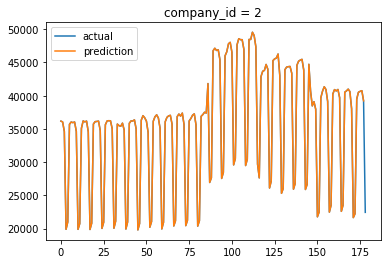

In [45]:
act_arr = list(dftest.loc[dftest['company_id'] == 2]['volume_tests'])

# Plot comparison Predicted vs Actual
pyplot.plot(act_arr, label='actual')
pyplot.plot(pred_arr, label='prediction')
pyplot.legend()
plt.title("company_id = %s" % (str(2)))
pyplot.show()

In [46]:
for i in range(len(pred_arr)):
    print('Day=%d, Expected=%.2f, Predicted=%.2f' % (i+1, act_arr[i], pred_arr[i][0]))

Day=1, Expected=36174.00, Predicted=36174.00
Day=2, Expected=36055.00, Predicted=36055.00
Day=3, Expected=34601.00, Predicted=34601.00
Day=4, Expected=19900.00, Predicted=19900.00
Day=5, Expected=20997.00, Predicted=20997.00
Day=6, Expected=35692.00, Predicted=35692.00
Day=7, Expected=36041.00, Predicted=36041.00
Day=8, Expected=35948.00, Predicted=35948.00
Day=9, Expected=36042.00, Predicted=36042.00
Day=10, Expected=34633.00, Predicted=34633.00
Day=11, Expected=19893.00, Predicted=19893.00
Day=12, Expected=20746.00, Predicted=20746.00
Day=13, Expected=35112.00, Predicted=35112.00
Day=14, Expected=36206.00, Predicted=36206.00
Day=15, Expected=36065.00, Predicted=36065.00
Day=16, Expected=36181.00, Predicted=36181.00
Day=17, Expected=34566.00, Predicted=34566.00
Day=18, Expected=19873.00, Predicted=19873.00
Day=19, Expected=20812.00, Predicted=20812.00
Day=20, Expected=35740.00, Predicted=35740.00
Day=21, Expected=36099.00, Predicted=36099.00
Day=22, Expected=36125.00, Predicted=36125.

## Prepare Prediction

In [47]:
# get highest scoring algorithm
max_val = max(scores.items(), key=operator.itemgetter(1))[0]
print("The highest scoring algorithm was %s, with score of %.3f" % (max_val, scores[max_val]))

The highest scoring algorithm was RFR, with score of 0.923


In [78]:
models = ['SVR', 'RFR', 'RidgeCV', 'LassoCV']
total_pred = pd.DataFrame()

for model in models:
    prediction = pd.DataFrame()
    prediction.insert(0, 'company_id', dftest['company_id'])
    prediction.insert(1, 'model', model)
    prediction.insert(2, 'time', dftest['time'])
    prediction.insert(3, 'volume_tests', predictions[max_val])
    total_pred = total_pred.append(prediction)
total_pred

,company_id,model,time,volume_tests
56429,2,SVR,2019-12-25,39401.372917
56548,2,SVR,2019-12-26,38975.362333
56667,2,SVR,2019-12-27,40442.917398
56786,2,SVR,2019-12-28,21797.074542
56905,2,SVR,2019-12-29,21122.865000
...,...,...,...,...
79756,2,LassoCV,2020-06-16,38929.836097
79837,2,LassoCV,2020-06-17,38748.012764
79921,2,LassoCV,2020-06-18,38643.673734
80005,2,LassoCV,2020-06-19,39317.285624


## Evaluate Model

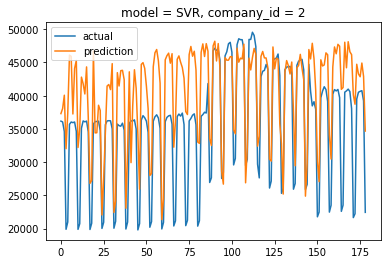

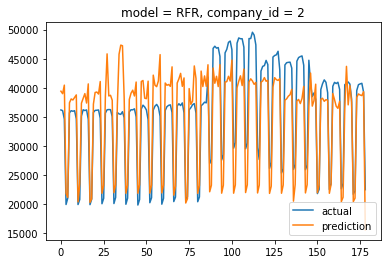

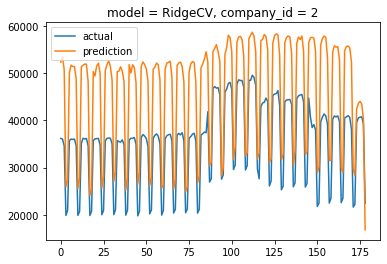

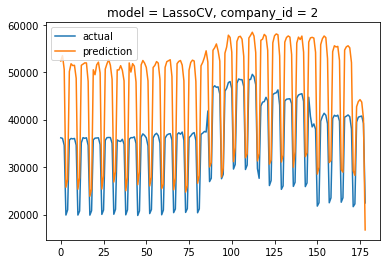

In [77]:
company_id = dftest.company_id.unique()
company_id = np.sort(company_id)

models = ['SVR', 'RFR', 'RidgeCV', 'LassoCV']

for company in company_id:
    for model in models:
        # Plot comparison Predicted vs Actual
        pyplot.plot(list(dftest.loc[dftest['company_id'] == company]['volume_tests']), label='actual')
        pyplot.plot(list(predictions[model]), label='prediction')
        pyplot.legend()
        plt.title("model = %s, company_id = %s" % (str(model), str(company)))
        pyplot.show()

In [76]:
# Summary of the predicted vs actual vol. of tests
company_id = dftest.company_id.unique()
company_id = np.sort(company_id)
dates = dftest.time.unique()

total_accuracy = []
for company in company_id:
    accuracy_scores = []
    for date in dates:
        
        if len(dftest.loc[(dftest['company_id'] == company) &
                          (dftest['time'] == date)]['volume_tests'].values) > 0:
            actual = dftest.loc[(dftest['company_id'] == company) &
                                (dftest['time'] == date)]['volume_tests'].values
            predicted = prediction.loc[(prediction['company_id'] == company) &
                                        (prediction['time'] == date)]['volume_tests'].values
            
            if actual > predicted:
                score = predicted / actual * 100
            else:
                score = actual / predicted * 100
                
            if score > 0:
                accuracy_scores.append(score)
            print('Company: %s Date: %s Expected: %.2f Predicted: %.2f Accuracy: %.2f%%' % (company, date, actual, predicted, score))
    
    print('Avg. Accuracy %.2f%% (+/- %.2f%%) \n' % (np.mean(accuracy_scores), np.std(accuracy_scores)))
    total_accuracy.append(np.mean(accuracy_scores))

print('Total Avg. Accuracy %.2f%% (+/- %.2f%%) \n' % (np.mean(total_accuracy), np.std(total_accuracy)))


Company: 2 Date: 2019-12-25 Expected: 36174.00 Predicted: 39401.37 Accuracy: 91.81%
Company: 2 Date: 2019-12-26 Expected: 36055.00 Predicted: 38975.36 Accuracy: 92.51%
Company: 2 Date: 2019-12-27 Expected: 34601.00 Predicted: 40442.92 Accuracy: 85.56%
Company: 2 Date: 2019-12-28 Expected: 19900.00 Predicted: 21797.07 Accuracy: 91.30%
Company: 2 Date: 2019-12-29 Expected: 20997.00 Predicted: 21122.87 Accuracy: 99.40%
Company: 2 Date: 2019-12-30 Expected: 35692.00 Predicted: 37407.33 Accuracy: 95.41%
Company: 2 Date: 2019-12-31 Expected: 36041.00 Predicted: 38069.95 Accuracy: 94.67%
Company: 2 Date: 2020-01-01 Expected: 35948.00 Predicted: 37887.89 Accuracy: 94.88%
Company: 2 Date: 2020-01-02 Expected: 36042.00 Predicted: 38310.38 Accuracy: 94.08%
Company: 2 Date: 2020-01-03 Expected: 34633.00 Predicted: 38762.23 Accuracy: 89.35%
Company: 2 Date: 2020-01-04 Expected: 19893.00 Predicted: 20345.97 Accuracy: 97.77%
Company: 2 Date: 2020-01-05 Expected: 20746.00 Predicted: 23425.06 Accuracy:

Company: 2 Date: 2020-05-06 Expected: 44369.00 Predicted: 38548.57 Accuracy: 86.88%
Company: 2 Date: 2020-05-07 Expected: 44401.00 Predicted: 38801.64 Accuracy: 87.39%
Company: 2 Date: 2020-05-08 Expected: 43378.00 Predicted: 39716.20 Accuracy: 91.56%
Company: 2 Date: 2020-05-09 Expected: 25934.00 Predicted: 20481.08 Accuracy: 78.97%
Company: 2 Date: 2020-05-10 Expected: 26789.00 Predicted: 23348.40 Accuracy: 87.16%
Company: 2 Date: 2020-05-11 Expected: 44571.00 Predicted: 37734.27 Accuracy: 84.66%
Company: 2 Date: 2020-05-12 Expected: 45190.00 Predicted: 37981.68 Accuracy: 84.05%
Company: 2 Date: 2020-05-13 Expected: 45359.00 Predicted: 37273.71 Accuracy: 82.17%
Company: 2 Date: 2020-05-14 Expected: 45473.00 Predicted: 38160.26 Accuracy: 83.92%
Company: 2 Date: 2020-05-15 Expected: 43873.00 Predicted: 40217.72 Accuracy: 91.67%
Company: 2 Date: 2020-05-16 Expected: 25890.00 Predicted: 21891.05 Accuracy: 84.55%
Company: 2 Date: 2020-05-17 Expected: 26658.00 Predicted: 23297.35 Accuracy: